Experiment-7 K-Means


Name : Amishi Gupta

Roll No. : 23/CS/048

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import time

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/Mall_Customers.csv'

df_raw = pd.read_csv(file_path)

print("Raw Data Head")
print(df_raw.head())

col_name = df_raw.columns[0]
print(f"\nSingle column name found:{col_name}")

new_cols = col_name.split(',')
print(f"Split into new columns:{new_cols}")

df = df_raw[col_name].str.split(',', expand=True)
df.columns = new_cols

print("\nCorrected DataFrame Head")
print(df.head())

print("\nCorrected Data Info")
df['CustomerID'] = pd.to_numeric(df['CustomerID'])
df['Age'] = pd.to_numeric(df['Age'])
df['Annual Income (k$)'] = pd.to_numeric(df['Annual Income (k$)'])
df['Spending Score (1-100)'] = pd.to_numeric(df['Spending Score (1-100)'])

print(df.info())

print("\nMissing Values")
print(df.isnull().sum())

X_df = df.iloc[:, [2, 3, 4]]
print("\nFeatures for Clustering (X_df)")
print(X_df.head())

Raw Data Head
  CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0                                    1,Male,19,15,39             
1                                    2,Male,21,15,81             
2                                   3,Female,20,16,6             
3                                  4,Female,23,16,77             
4                                  5,Female,31,17,40             

Single column name found:CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
Split into new columns:['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Corrected DataFrame Head
  CustomerID  Gender Age Annual Income (k$) Spending Score (1-100)
0          1    Male  19                 15                     39
1          2    Male  21                 15                     81
2          3  Female  20                 16                      6
3          4  Female  23                 16                     77
4          5  Female  31            

Scaled Data Head
        Age  Annual Income (k$)  Spending Score (1-100)
0 -1.424569           -1.738999               -0.434801
1 -1.281035           -1.738999                1.195704
2 -1.352802           -1.700830               -1.715913
3 -1.137502           -1.700830                1.040418
4 -0.563369           -1.662660               -0.395980

Feature Distributions


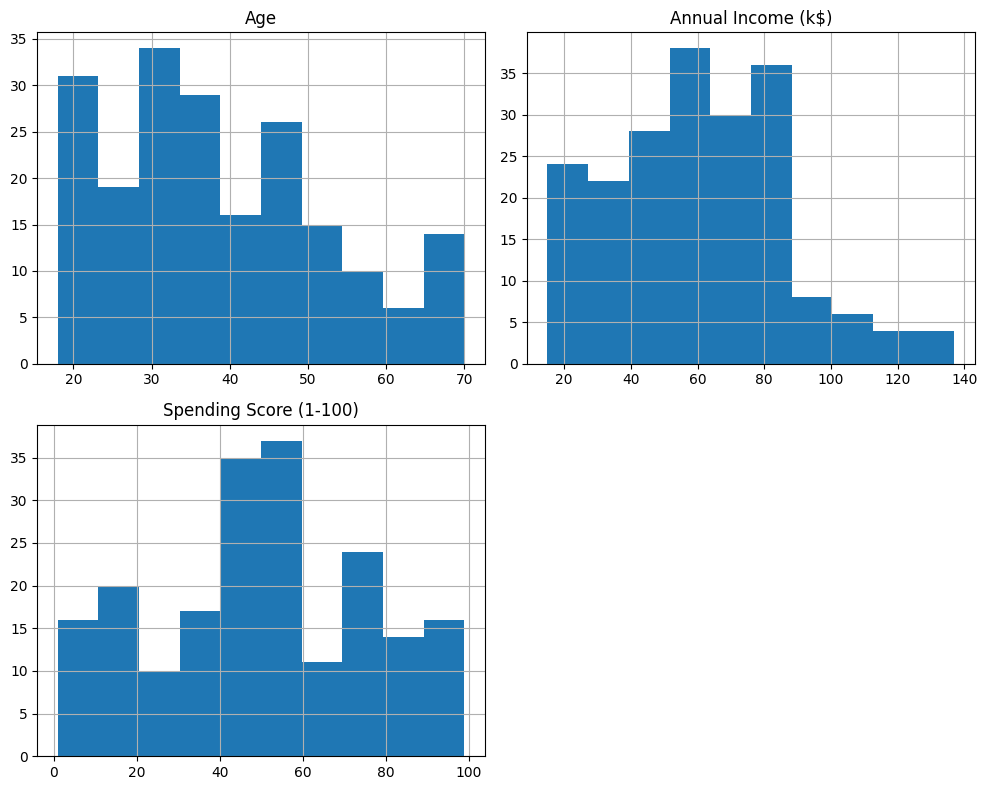


Scatter Matrix of Features


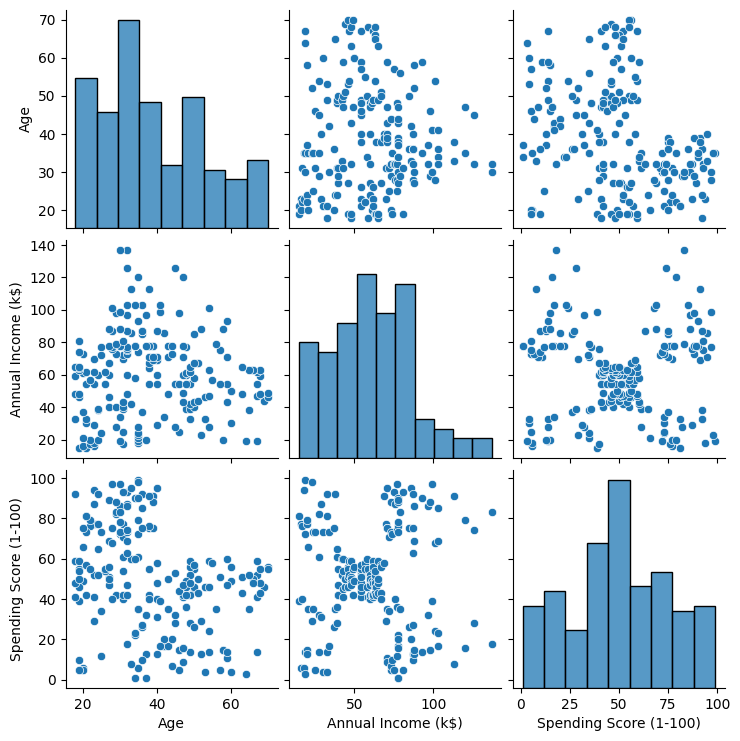

In [5]:
#Preprocessing (Scaling) and Visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_df.columns)

print("Scaled Data Head")
print(X_scaled_df.head())

print("\nFeature Distributions")
X_df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

print("\nScatter Matrix of Features")
sns.pairplot(X_df)
plt.show()

In [6]:
#Part A - K-Means Helper Functions
def initialize_centroids_random(X, k, rs=None):
    if rs:
        np.random.seed(rs)
    idx = np.random.permutation(X.shape[0])[:k]
    return X[idx]

def initialize_centroids_plus(X, k, rs=None):
    if rs:
        np.random.seed(rs)

    c = [X[np.random.randint(X.shape[0])]]
    for _ in range(1, k):
        d2 = np.array([min([np.linalg.norm(x-c_i)**2 for c_i in c]) for x in X])
        p = d2 / d2.sum()
        idx = np.random.choice(len(X), p=p)
        c.append(X[idx])
    return np.array(c)

def assign_clusters(X, c):
    d = np.linalg.norm(X[:, np.newaxis] - c, axis=2)
    return np.argmin(d, axis=1)

def update_centroids(X, l, k):
    c_new = np.empty((k, X.shape[1]))
    for i in range(k):
        pts = X[l == i]
        if len(pts) > 0:
            c_new[i] = pts.mean(axis=0)
        else:
            c_new[i] = X[np.random.randint(X.shape[0])]
    return c_new

In [8]:
#Main K-Means Function
def kmeans(X, k, max_iters=100, tol=1e-4, rs=None, init_method='plus'):
    if init_method == 'plus':
        c = initialize_centroids_plus(X, k, rs)
    else:
        c = initialize_centroids_random(X, k, rs)

    for i in range(max_iters):
        c_old = c
        l = assign_clusters(X, c)
        c = update_centroids(X, l, k)
        shift = np.linalg.norm(c - c_old)

        if shift < tol:
            break

    inertia = np.sum([np.linalg.norm(X[j] - c[l[j]])**2 for j in range(len(X))])
    return c, l, i + 1, inertia

In [9]:
#Comparison of Initialization
K_TEST = 5
RS = 42

print("Comparing Initialization Methods (k=5)")

start_plus = time.time()
c_plus, l_plus, iters_plus, inertia_plus = kmeans(X_scaled, K_TEST, rs=RS, init_method='plus')
time_plus = time.time() - start_plus
print(f"K-Means++:\n  Inertia: {inertia_plus:.4f}\n  Iterations: {iters_plus}\n  Time: {time_plus:.4f}s")

start_rand = time.time()
c_rand, l_rand, iters_rand, inertia_rand = kmeans(X_scaled, K_TEST, rs=RS, init_method='random')
time_rand = time.time() - start_rand
print(f"\nRandom Init:\n  Inertia: {inertia_rand:.4f}\n  Iterations: {iters_rand}\n  Time: {time_rand:.4f}s")

Comparing Initialization Methods (k=5)
K-Means++:
  Inertia: 168.7618
  Iterations: 6
  Time: 0.0367s

Random Init:
  Inertia: 168.2476
  Iterations: 9
  Time: 0.0033s


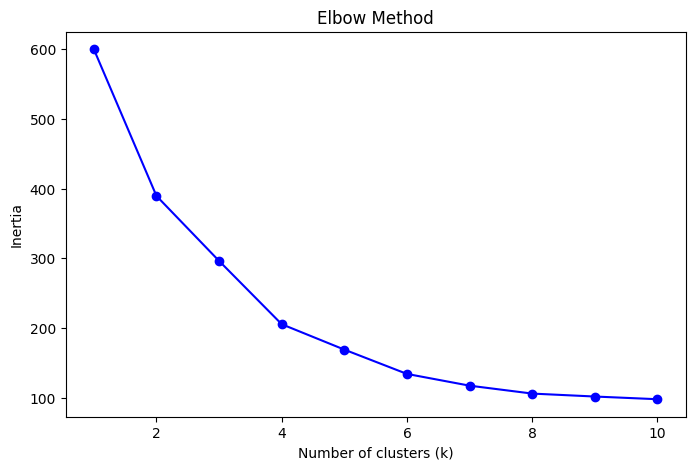

In [10]:
#Elbow Method
k_range = range(1, 11)
inertias = []

for k in k_range:
    _, _, _, inertia = kmeans(X_scaled, k, rs=RS)
    inertias.append(inertia)


plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

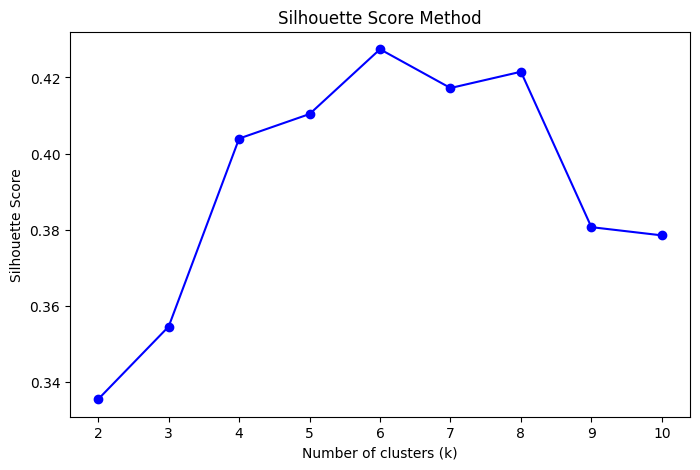

In [13]:
#Silhouette Score
k_range_sil = range(2, 11)
sil_scores = []

for k in k_range_sil:
    _, l, _, _ = kmeans(X_scaled, k, rs=RS)
    score = silhouette_score(X_scaled, l)
    sil_scores.append(score)


plt.figure(figsize=(8, 5))
plt.plot(k_range_sil, sil_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

In [14]:
#Run Final Algorithm
K_FINAL = 5
c, l, iters, inertia = kmeans(X_scaled, K_FINAL, rs=RS)

print(f"Final K-Means (k={K_FINAL})")
print(f"Final Centroids (Scaled):\n {c}")
print(f"\nTotal Iterations: {iters}")
print(f"Final Inertia: {inertia:.4f}")

print("\nCluster Sizes")
cluster_counts = pd.Series(l).value_counts().sort_index()
print(cluster_counts)

Final K-Means (k=5)
Final Centroids (Scaled):
 [[ 1.19862745 -0.46098141 -0.32703818]
 [-0.44191719  0.99158305  1.23950275]
 [-0.97439592 -1.32954532  1.13217788]
 [ 0.17329545  1.06645385 -1.2980103 ]
 [-0.78172248 -0.40306917 -0.21591396]]

Total Iterations: 6
Final Inertia: 168.7618

Cluster Sizes
0    58
1    39
2    22
3    34
4    47
Name: count, dtype: int64


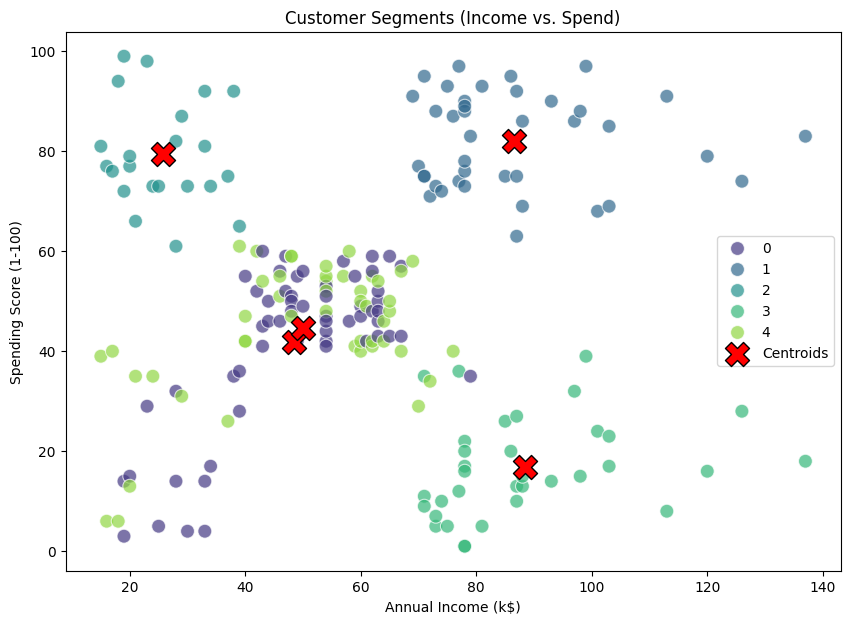

In [15]:
#2D and 3D Visualizations
df_analysis = X_df.copy()
df_analysis['Cluster'] = l

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_analysis,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Cluster',
    palette=sns.color_palette('viridis', n_colors=K_FINAL),
    s=100,
    alpha=0.7
)
c_unscaled = scaler.inverse_transform(c)
plt.scatter(
    c_unscaled[:, 1],
    c_unscaled[:, 2],
    marker='X',
    s=300,
    c='red',
    edgecolor='black',
    label='Centroids'
)
plt.title('Customer Segments (Income vs. Spend)')
plt.legend()
plt.show()

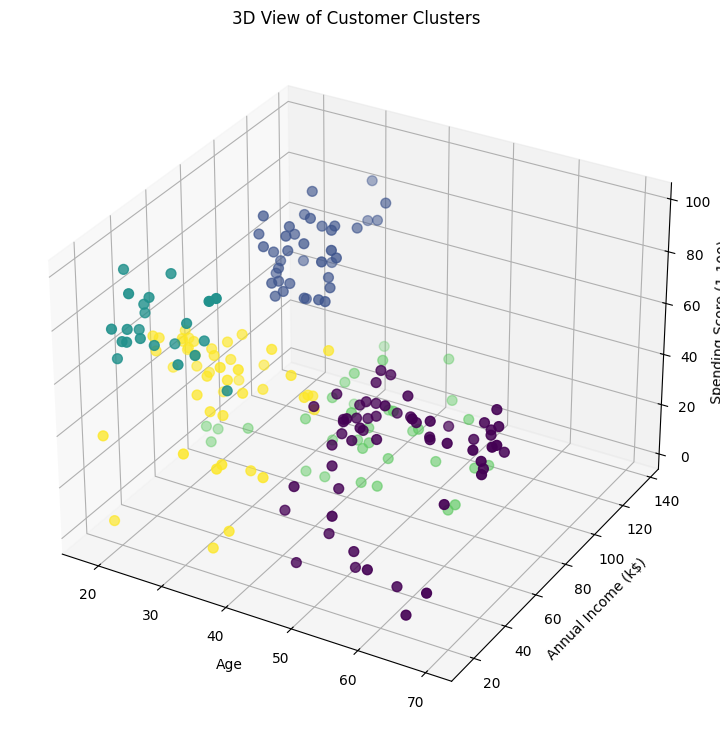

In [16]:
#3D Scatter Plot

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    df_analysis['Age'],
    df_analysis['Annual Income (k$)'],
    df_analysis['Spending Score (1-100)'],
    c=df_analysis['Cluster'],
    cmap='viridis',
    s=50
)

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D View of Customer Clusters')
plt.show()

In [17]:
#Cluster Interpretation (Statistics)
cluster_stats = df_analysis.groupby('Cluster').mean()
cluster_stats['Cluster Size'] = cluster_counts

print("Cluster Profiles (Averages)")
print(cluster_stats.sort_values(by='Annual Income (k$)', ascending=False))

Cluster Profiles (Averages)
               Age  Annual Income (k$)  Spending Score (1-100)  Cluster Size
Cluster                                                                     
3        41.264706           88.500000               16.764706            34
1        32.692308           86.538462               82.128205            39
4        27.957447           50.000000               44.638298            47
0        55.551724           48.482759               41.775862            58
2        25.272727           25.727273               79.363636            22


In [18]:
#scikit-learn Comparison
start_my = time.time()
c_my, l_my, iters_my, inertia_my = kmeans(
    X_scaled, K_FINAL, max_iters=300, tol=1e-4, rs=RS
)
time_my = time.time() - start_my

km_sk = KMeans(
    n_clusters=K_FINAL,
    init='k-means++',
    n_init=1,
    max_iter=300,
    tol=1e-4,
    random_state=RS
)

start_sk = time.time()
km_sk.fit(X_scaled)
time_sk = time.time() - start_sk

c_sk = km_sk.cluster_centers_
iters_sk = km_sk.n_iter_
inertia_sk = km_sk.inertia_

print("K-Means Implementation Comparison")
results = {
    'Implementation': ['My Scratch', 'scikit-learn'],
    'Inertia': [inertia_my, inertia_sk],
    'Iterations': [iters_my, iters_sk],
    'Runtime (s)': [time_my, time_sk]
}
comp_df = pd.DataFrame(results)
print(comp_df)

print("\nCentroid Comparison (Sorted)")
print("My Centroids (Sorted):\n", np.sort(c_my, axis=0))
print("\nSKlearn Centroids (Sorted):\n", np.sort(c_sk, axis=0))

K-Means Implementation Comparison
  Implementation     Inertia  Iterations  Runtime (s)
0     My Scratch  168.761788           6     0.053266
1   scikit-learn  169.891498           7     0.131927

Centroid Comparison (Sorted)
My Centroids (Sorted):
 [[-0.97439592 -1.32954532 -1.2980103 ]
 [-0.78172248 -0.46098141 -0.32703818]
 [-0.44191719 -0.40306917 -0.21591396]
 [ 0.17329545  0.99158305  1.13217788]
 [ 1.19862745  1.06645385  1.23950275]]

SKlearn Centroids (Sorted):
 [[-0.93876351 -1.31473131 -1.23126963]
 [-0.86957306 -0.49388609 -0.36060916]
 [-0.42880597 -0.23851652 -0.32971553]
 [ 0.39737911  0.97484722  0.95680216]
 [ 1.17882975  1.11508909  1.21608539]]
